## Setup and Import Libraries

In [ ]:
import os
import time
import faiss
from __future__ import annotations
from typing import TypedDict, List, Optional
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # 384-dim
VECTOR_DIM = 384

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45

# Optional TTL for cache entries (seconds). 0 = disabled.
CACHE_TTL_SEC = 0

In [6]:
EMBEDDINGS = HuggingFaceEmbeddings(model_name=EMBED_MODEL)
LLM = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

## Creating State

In [7]:
class RAGState(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

## Creating Cache

In [ ]:
qa_index = faiss.IndexFlatL2(VECTOR_DIM) 

QA_CACHE = FAISS(
    embedding_function=EMBEDDINGS,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

QA_CACHE

## Create RAG Store

In [9]:
RAG_STORE = FAISS.from_texts(
    texts=[
        "LangGraph lets you compose stateful LLM workflows as graphs.",
        "In LangGraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.",
        "Retrieval-Augmented Generation (RAG) retrieves external context and injects it into prompts.",
        "Semantic caching reuses prior answers when new questions are semantically similar."
    ],
    embedding=EMBEDDINGS,
)

## Creating Nodes

In [11]:
def normalize_query(state: RAGState) -> RAGState:
    question = (state["question"] or "").strip()
    state["normalized_question"] = question.lower()
    return state

In [12]:
def semantic_cache_lookup(state: RAGState) -> RAGState:
    question = state["normalized_question"]
    state["cache_hit"] = False  # default

    if not question:
        return state

    # ✅ Guard: FAISS crashes if ntotal == 0 and you ask for k>0
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
        return state

    # For FAISS L2 wrapper, this returns (Document, distance) with lower=better
    hits = QA_CACHE.similarity_search_with_score(question, k=CACHE_TOP_K)
    if not hits:
        return state

    best_doc, dist = hits[0]

    # Optional TTL
    if CACHE_TTL_SEC > 0:
        time_stamp = best_doc.metadata.get("ts")
        if time_stamp is None or (time.time() - float(time_stamp)) > CACHE_TTL_SEC:
            return state

    # L2 distance gate (lower = more similar)
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True

    return state

In [13]:
def respond_from_cache(state: RAGState) -> RAGState:
    return state

In [14]:
def retrieve(state: RAGState) -> RAGState:
    question = state["normalized_question"]
    documents = RAG_STORE.similarity_search(question, k=RETRIEVE_TOP_K)
    state["context_docs"] = documents
    return state

In [ ]:
def generate(state: RAGState) -> RAGState:
    question = state["question"]
    documents = state.get("context_docs", [])
    context = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(documents, start=1)])

    system = (
        "You are a precise RAG assistant. Use the context when helpful. "
        "Cite with [doc-i] markers if you use a fact from the context."
    )
    user = f"Question: {question}\n\nContext:\n{context}\n\nWrite a concise answer with citations."

    response = LLM.invoke([{"role": "system", "content": system},
                       {"role": "user", "content": user}])
    state["answer"] = response.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(documents) + 1)]
    return state

In [16]:
def cache_write(state: RAGState) -> RAGState:
    question = state["normalized_question"]
    answer = state.get("answer")
    if not question or not answer:
        return state

    QA_CACHE.add_texts(
        texts=[question],
        metadatas=[{
            "answer": answer,
            "ts": time.time(),
        }]
    )
    return state

## Create Graph

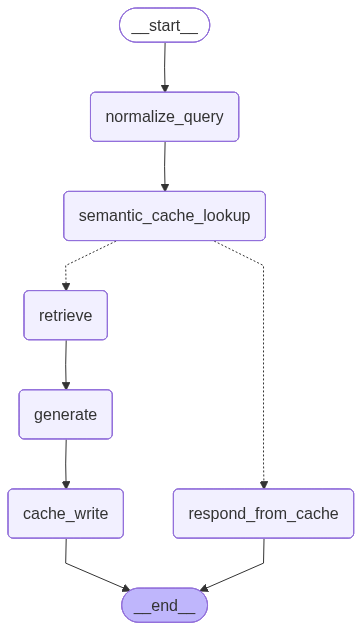

In [17]:
workflow = StateGraph(RAGState)

# Adding Nodes
workflow.add_node(node="normalize_query", action=normalize_query)
workflow.add_node(node="semantic_cache_lookup", action=semantic_cache_lookup)
workflow.add_node(node="respond_from_cache", action=respond_from_cache)
workflow.add_node(node="retrieve", action=retrieve)
workflow.add_node(node="generate", action=generate)
workflow.add_node(node="cache_write", action=cache_write)

# Set Entry Point
workflow.set_entry_point(key="normalize_query")

# Add Edges
workflow.add_edge(start_key="normalize_query", end_key="semantic_cache_lookup")

def _branch(state: RAGState) -> str:
    return "respond_from_cache" if state.get("cache_hit") else "retrieve"

workflow.add_conditional_edges(
    source="semantic_cache_lookup",
    path=_branch,
    path_map={
        "respond_from_cache": "respond_from_cache",
        "retrieve": "retrieve"
    }
)

workflow.add_edge(start_key="respond_from_cache", end_key=END)
workflow.add_edge(start_key="retrieve", end_key="generate")
workflow.add_edge(start_key="generate", end_key="cache_write")
workflow.add_edge(start_key="cache_write", end_key=END)

# Add Memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

graph

In [19]:
thread_configuration = {"configurable": {"thread_id": "demo-user-1"}}

In [20]:
question1 = "What is LangGraph?"
response1 = graph.invoke({"question": question1, "context_docs": [], "citations": []}, thread_configuration)

print("Answer:", response1["answer"])
print("Citations:", response1.get("citations"))
print("Cache hit?:", response1.get("cache_hit"))

Answer: LangGraph is a framework that allows users to compose stateful workflows for large language models (LLMs) in the form of graphs, enabling the management of complex interactions and data flows [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL), enhancing efficiency [doc-1].
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [21]:
question2 = "Explain about LangGraph "
response2 = graph.invoke({"question": question2, "context_docs": [], "citations": []}, thread_configuration)

print("Answer:", response2["answer"])
print("Citations:", response2.get("citations"))
print("Cache hit?:", response2.get("cache_hit"))

Answer: LangGraph is a framework that allows users to compose stateful workflows for large language models (LLMs) in the form of graphs, enabling the management of complex interactions and data flows [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL), enhancing efficiency [doc-1].
Citations: ['(cache)']
Cache hit?: True


In [22]:
question3 = "Explain about LangGraph agents"
response3 = graph.invoke({"question": question3, "context_docs": [], "citations": []}, thread_configuration)

print("Answer:", response3["answer"])
print("Citations:", response3.get("citations"))
print("Cache hit?:", response3.get("cache_hit"))

Answer: LangGraph agents are designed to facilitate the composition of stateful workflows using large language models (LLMs) in a graph structure, allowing for efficient management of data and processes [doc-2]. They utilize features like node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL), enhancing performance by reducing redundant computations [doc-1]. Additionally, LangGraph incorporates retrieval-augmented generation (RAG) techniques, which retrieve external context to enrich prompts, and semantic caching, which reuses previous answers for new, semantically similar questions [doc-3][doc-4]. This combination of features enables LangGraph agents to operate effectively in dynamic and context-rich environments.
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [23]:
question4 = "Explain about agents in Langgraph"
response4 = graph.invoke({"question": question3, "context_docs": [], "citations": []}, thread_configuration)

print("Answer:", response4["answer"])
print("Citations:", response4.get("citations"))
print("Cache hit?:", response4.get("cache_hit"))

Answer: LangGraph agents are designed to facilitate the composition of stateful workflows using large language models (LLMs) in a graph structure, allowing for efficient management of data and processes [doc-2]. They utilize features like node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL), enhancing performance by reducing redundant computations [doc-1]. Additionally, LangGraph incorporates retrieval-augmented generation (RAG) techniques, which retrieve external context to enrich prompts, and semantic caching, which reuses previous answers for new, semantically similar questions [doc-3][doc-4]. This combination of features enables LangGraph agents to operate effectively in dynamic and context-rich environments.
Citations: ['(cache)']
Cache hit?: True
